#Trabajo:

Análisis de la criptomoneda Dogecoin utilizando modelos ARIMA, SARIMA y Suavizamiento Exponencial durante el periodo de 2021 al 6 de julio de ese mismo año, con el fin de determinar cuál presenta el mejor ajuste al comportamiento de su precio histórico.

*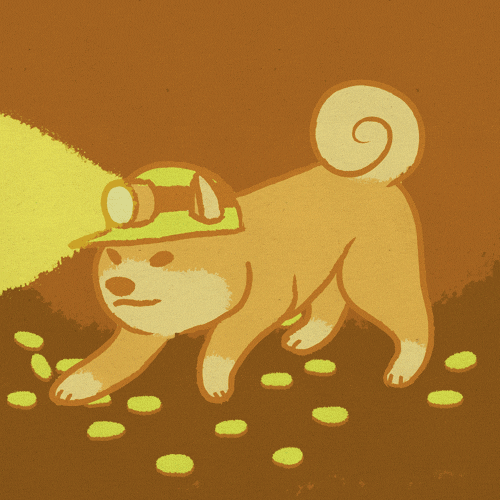 *

#Librerias

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing

# Descripción del set de datos

El set de datos contiene el historial de precios diarios en dolares (USD) desde el 28 de abril de 2013 hasta el 6 de Julio de 2021, de la cripto moneda DogeCoin

Columnas:

* Date (Fecha): día de observación

* Open (Apertura): precio de apertura en el día indicado

* High (Máximo): precio más alto alcanzado en el día

* Low  (Mínimo): precio más bajo alcanzado en el día

* Close (Cierre): precio de cierre en el día

* Volume (Volumen): volumen de transacciones durante el día

* Market Cap (Capitalización de mercado): capitalización de mercado en USD


#Definición de la variable objetivo (variable Y)


La variable objetivo (target) para el modelo de pronóstico por Serie de tiempo es el precio de cierre (Close), ya que buscamos predecir su comportamiento futuro.

# Análisis de la serie temporal

In [9]:
#cargamos el set de datos
df=pd.read_csv('https://raw.githubusercontent.com/Motsof/Regresion/refs/heads/main/Datos/coin_Dogecoin.csv')
#Observamos el dataframe

In [10]:
#Observamos los tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2760 non-null   int64  
 1   Name       2760 non-null   object 
 2   Symbol     2760 non-null   object 
 3   Date       2760 non-null   object 
 4   High       2760 non-null   float64
 5   Low        2760 non-null   float64
 6   Open       2760 non-null   float64
 7   Close      2760 non-null   float64
 8   Volume     2760 non-null   float64
 9   Marketcap  2760 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 215.8+ KB


In [11]:
#Buscamos nulos
print(df.isnull().sum())

SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64


In [12]:
#Verificar si existen valores duplicados
df.duplicated().sum()

np.int64(0)

In [13]:
#Verificamos las distintas metricas del DF
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2.760000e+03,2.760000e+03
mean,1380.500000,0.014964,0.012402,0.013669,0.013763,4.326321e+08,1.760533e+09
std,796.887696,0.069103,0.055536,0.062347,0.062559,2.807320e+09,8.115186e+09
min,1.000000,0.000089,0.000085,0.000087,0.000087,0.000000e+00,1.509085e+06
25%,690.750000,0.000231,0.000222,0.000227,0.000226,2.536138e+05,2.337892e+07
50%,1380.500000,0.001914,0.001772,0.001849,0.001844,5.582480e+06,2.135789e+08
75%,2070.250000,0.002986,0.002796,0.002900,0.002899,5.098244e+07,3.488812e+08
max,2760.000000,0.737567,0.608168,0.687801,0.684777,6.941068e+10,8.868082e+10


In [14]:
#Quitamos la hora de la fecha
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [15]:
#Convertimos la fecha a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

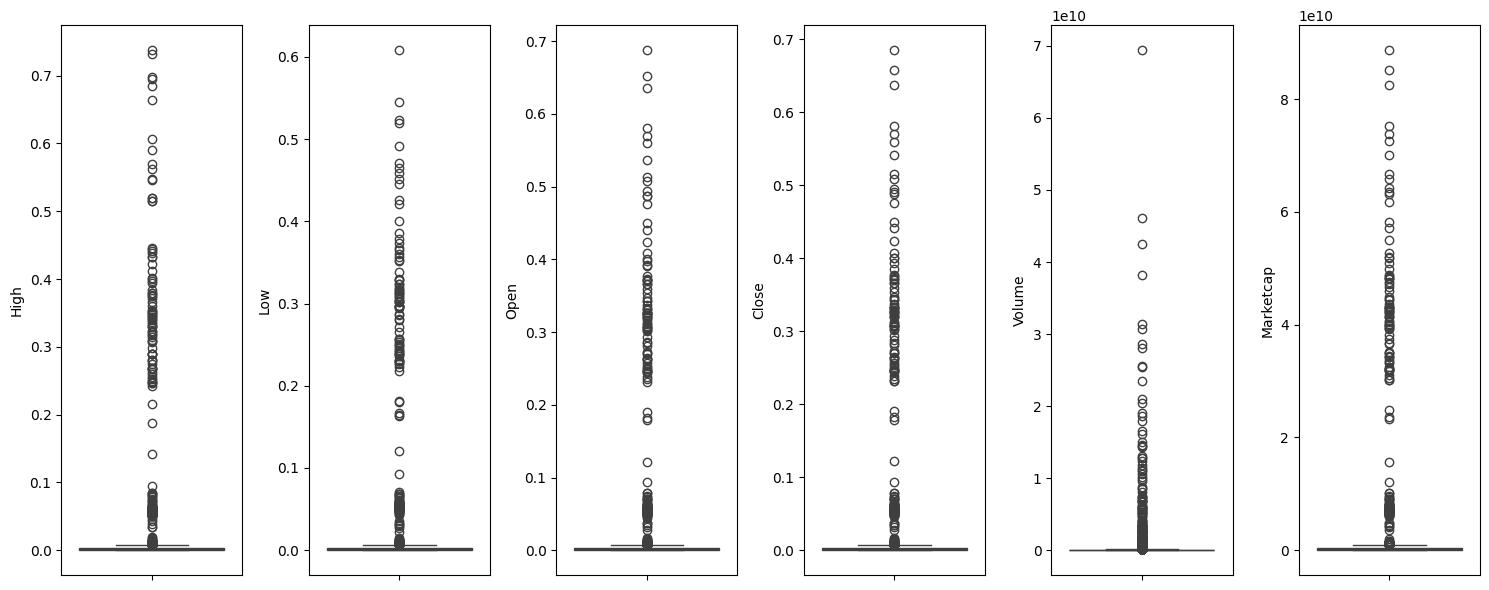

In [16]:
#Vamos a generar un diagrama de caja y bigotes para nuestras variables, intentando encontrar outliers
var=['High', 'Low', 'Open', 'Close', 'Volume','Marketcap']
fig, axes = plt.subplots(1, len(var), figsize=(15,6))

for ax, var in zip(axes, var):
    ax = sns.boxplot( y=var, data=df, ax=ax)
plt.tight_layout()

Como podemos observar, todas las variables cuentan con outlers

In [17]:
#Traemos solo la varible de cierre y de date
TS=df[['Date','Close']]

In [18]:
#ponemos de index la fecha
TS.set_index('Date',inplace=True)

In [19]:
#Cmabia el nombre de Close por Precio
TS = TS.rename(columns={'Close': 'Precio'})

In [20]:
#Checamos su estadsitica descriptiva
TS.describe()

,Precio
count,2760.000000
mean,0.013763
std,0.062559
min,0.000087
25%,0.000226
50%,0.001844
75%,0.002899
max,0.684777


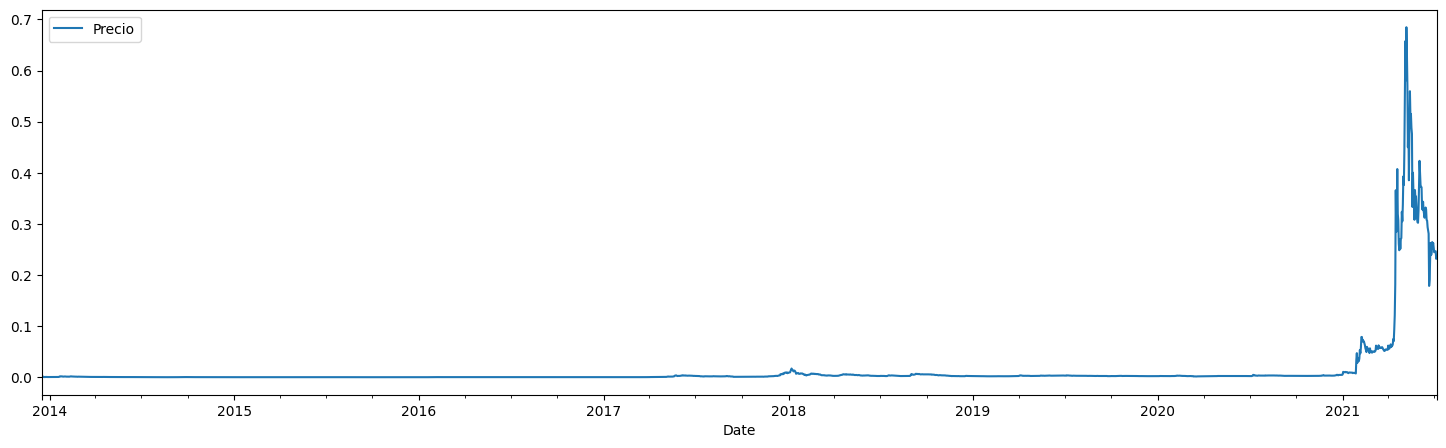

In [21]:
#graficamos la Serie de Tiempo
TS.plot(figsize=(18,5))
plt.show()

Viendo este grafico podemos ver que del periodo de 2014 a 2021 se conserva con un precio similar mas como una serie estacionaria constante, lo que nos puede arrojar problemas. Aunque en 2021 se nota un comportamiento diferente.

Dicho lo anterior se va a trabajar con el 2021 ya que lo anterior no muestra informacion relevante al modelo.

In [22]:
TS_reciente = TS.loc['2021-01-01':]

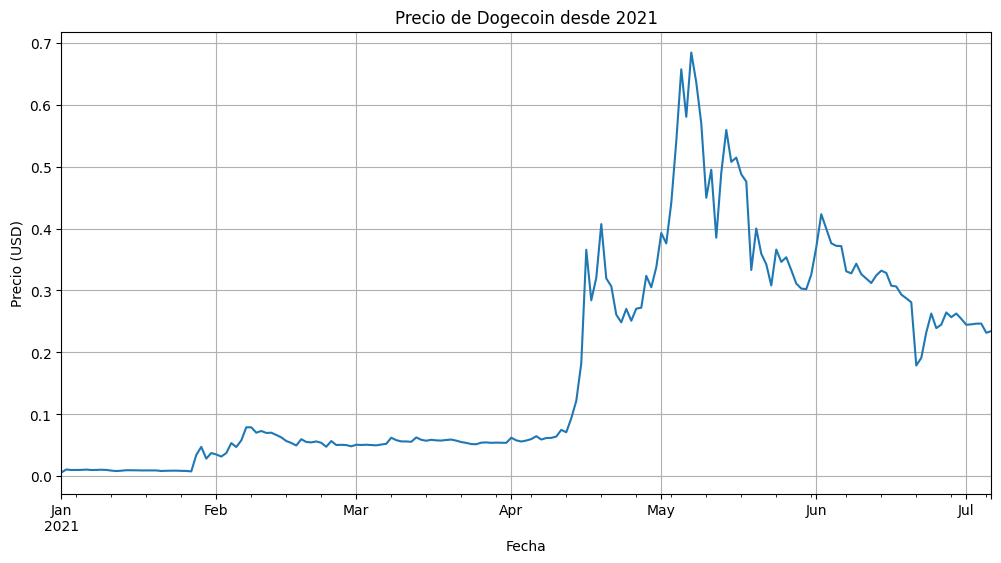

In [23]:
# Graficar
plt.figure(figsize=(12,6))
TS_reciente['Precio'].plot()
plt.title('Precio de Dogecoin desde 2021')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.show()

#Análisis estadístico y visual


Fechas train : 2021-01-01 00:00:00 --- 2021-06-01 00:00:00  (n=152)
Fechas test  : 2021-06-01 00:00:00 --- 2021-07-06 00:00:00  (n=36)


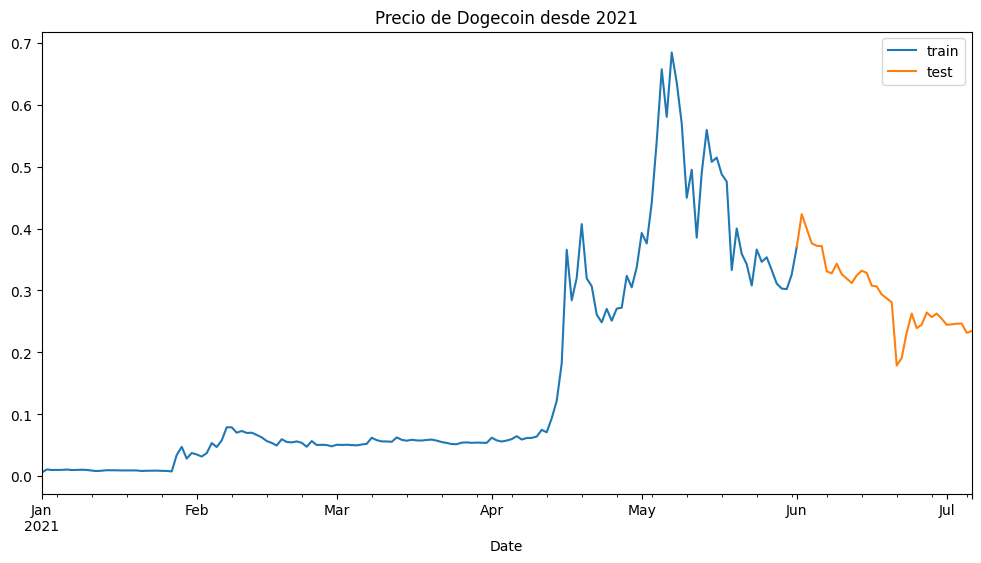

In [24]:
# Fechas de entrenamiento el 81% y 19% de prueba
fin_train = '2021-06-01'
#Mostramos la fehcas de entrenamiento (train)
print(
    f"Fechas train : {TS_reciente.index.min()} --- {TS_reciente.loc[:fin_train].index.max()}  "
    f"(n={len(TS_reciente.loc[:fin_train])})"
)
#Mostramos las fechas de prueba (test)
print(
    f"Fechas test  : {TS_reciente.loc[fin_train:].index.min()} --- {TS_reciente.loc[:].index.max()}  "
    f"(n={len(TS_reciente.loc[fin_train:])})"
)

#Definimos las varibles de train y test
TS_train = TS_reciente.loc[:fin_train]
TS_test  = TS_reciente.loc[fin_train:]

# Gráfico
fig, ax=plt.subplots(figsize=(12, 6))
TS_train.plot(ax=ax)
TS_test.plot(ax=ax)
ax.set_title('Precio de Dogecoin desde 2021')
ax.legend(['train', 'test'])
plt.show();

In [25]:
#Vemaos los residos de una descomposicion aditiva
TS_add = seasonal_decompose(TS_train,model='additive')

print(f'Promedio residuales descomposición aditiva: {TS_add.resid.mean()}')

Promedio residuales descomposición aditiva: -7.441683284741298e-05


In [26]:
#Vemaos los residos de una descomposicion multiplicativa
TS_mult = seasonal_decompose(TS_train,model='multiplicative')

print(f'Promedio residuales descomposición multiplicativa: {TS_mult.resid.mean()}')

Promedio residuales descomposición multiplicativa: 0.9901674263905214


Lo anterior indica que el error es menor con la descomposición aditiva y por tanto los componentes de tendencia y estacionalidad capturan mejor las variaciones presentes en una serie aditiva.

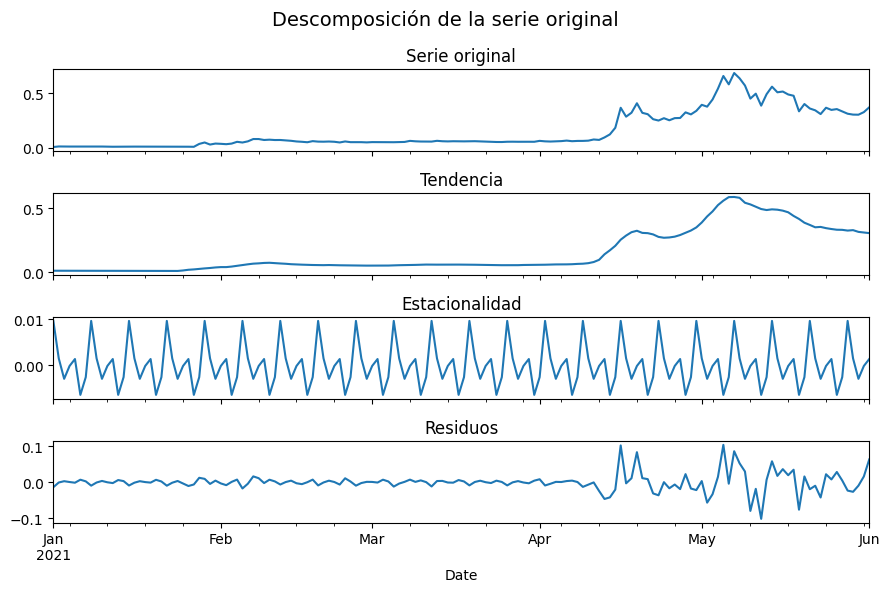

In [27]:
# Descomposición de la serie original y la serie diferenciada
res_decompose = seasonal_decompose(TS_train, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0])
axs[0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1])
axs[1].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2])
axs[2].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3])
axs[3].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original', fontsize=14)
fig.tight_layout();

La descomposición confirma que la serie combina tres rasgos claros:
1. Una tendencia casi plana de enero a finales de marzo, seguida de un salto brusco en abril a mayo y una leve corrección posterior.

2. Una estacionalidad semanal muy regular y estable en amplitud —los “dientes” se repiten cada siete días con oscilaciones pequeñas respecto al nivel de la serie.

3. Residuos que parecen ruido blanco en la mayor parte del periodo pero muestran heterocedasticidad justo después del cambio de nivel (picos negativos y varianza mayor en abril a mayo).

  En conjunto, esto sugiere que basta una primera diferencia para la tendencia más un término estacional semanal y quizá algún modelo que controle la volatilidad extra en el tramo de mayor variabilidad.

#Explicación de los parámetros así como de las pruebas conducidas


Purba de Estacionariedadad (Dickey-Fuller)

In [28]:
#Realizamos la prueba de Dickey-Fuller para comprobar si la serie original (TS) es estacionaria
resultado_adf = adfuller(TS['Precio'])
print(f'Estadístico ADF: {resultado_adf[0]}')
print(f'Valor p: {resultado_adf[1]}')
print('Valores críticos:')
for key, value in resultado_adf[4].items():
    print(f'   {key}: {value}')

Estadístico ADF: -2.9885293703782736
Valor p: 0.035979587145871676
Valores críticos:
   1%: -3.4327467254180486
   5%: -2.8625988999327463
   10%: -2.567333686767106


Si bien asumiamos que visualmente nuestra serie si era estacionaria sobre todo del periodo del 2014 a 2021, podemos confirmar con este Test que efectivamente si lo es ya que nos arroja que el valor pe es de 0.035<.05.

Sin embargo esto puede conducir a errores porque los datos estaban planos a cero y pueden dar una falsa apariencia de estacionariedad, ademas que nos interesa trabajar con el resto de 2021, por lo que buscamos hacer la prueba de 2021 en adelante

In [29]:
#Realizamos la prueba para los datos que vamos a trabajar
resultado_adf = adfuller(TS_train['Precio'])
print(f'Estadístico ADF: {resultado_adf[0]}')
print(f'Valor p: {resultado_adf[1]}')
print('Valores críticos:')
for key, value in resultado_adf[4].items():
    print(f'   {key}: {value}')

Estadístico ADF: -0.8391441731725178
Valor p: 0.8073525569630815
Valores críticos:
   1%: -3.476597917537401
   5%: -2.8818291230495543
   10%: -2.5775887982253085


El resultado nos arroja .80 que es mayor a .05 y por lo tanto no es estacionaria, lo cual tiene sentido por el compartamiento de subidas y bajadas que tenia. Ahora tendremos que diferenciarla

In [30]:

# Diferenciación de primer orden
diff_1 = TS_train['Precio'].diff().dropna()

# Muestra las primeras filas para verificar
print(diff_1.head())


Date
2021-01-02    0.004930
2021-01-03   -0.000844
2021-01-04   -0.000003
2021-01-05    0.000153
2021-01-06    0.000545
Name: Precio, dtype: float64


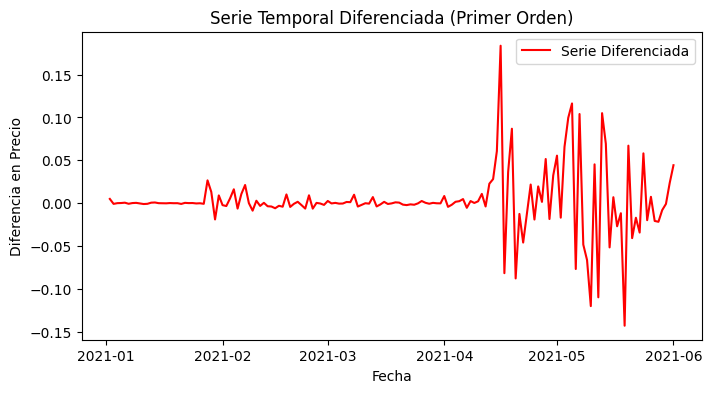

In [31]:
#Graficamos la serie diferenciada
plt.figure(figsize=(8, 4))
plt.plot(diff_1, label='Serie Diferenciada', color='red')
plt.title('Serie Temporal Diferenciada (Primer Orden)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio')
plt.legend()
plt.show()

Analizamos si la primera diferecia es estacionaria

In [32]:
# Realizamos el test de Dickey-Fuller sobre la serie diferenciada (primer orden)
resultado_adf = adfuller(diff_1)

# Imprimimos el resultado del test
print(f'Estadístico ADF: {resultado_adf[0]}')
print(f'Valor p: {resultado_adf[1]}')

print('Valores críticos:')
for key, value in resultado_adf[4].items():
    print(f'   {key}: {value}')


Estadístico ADF: -4.22256461316201
Valor p: 0.0006032862101595937
Valores críticos:
   1%: -3.4782936965183815
   5%: -2.882567574015525
   10%: -2.5779830117488745


lo cual nos indica que ya estamos trabajando sobre un modelo estacionario ya que p .00060<.05 y nuestro parametro **d=1**

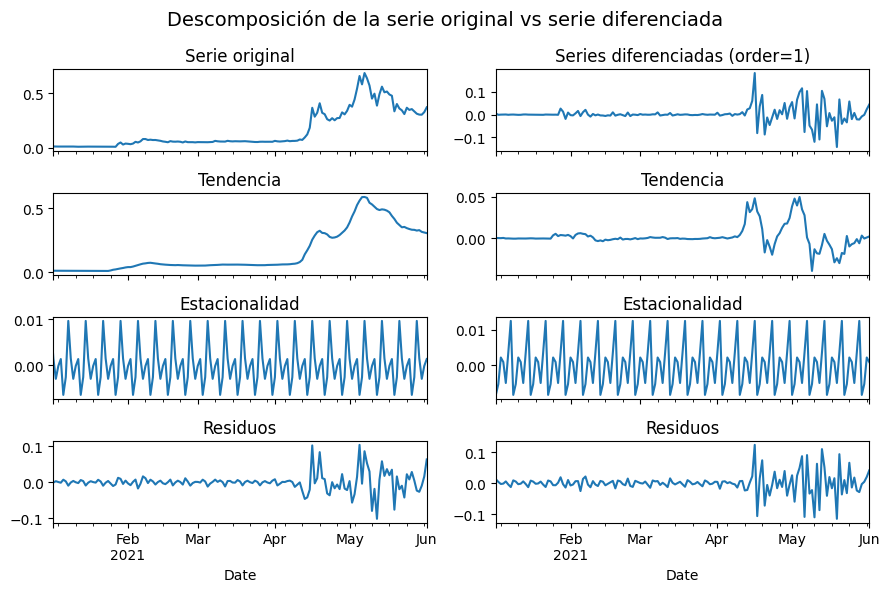

In [33]:
# Descomposición de la serie original y la serie diferenciada
res_decompose = seasonal_decompose(TS_train, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

Notamos que apesar de la diferenciacion la estacionalidad sigue marcada por lo que el parametro **D=1**

Para ver que parametros p y q utilizaremos un correlograma para ver si tiene ruido blanco

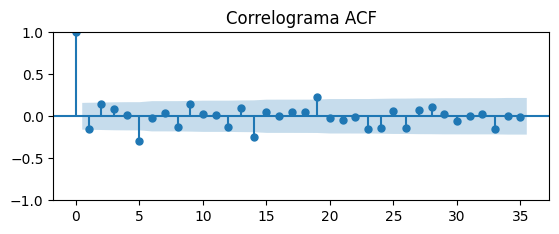

In [34]:
# Grafico del ACF (Autocorrelation Function)
# ACF (Autocorrelación)
plt.subplot(2, 1, 1)
plot_acf(diff_1, lags=35, ax=plt.gca())
plt.title('Correlograma ACF')
plt.show()


Viendo el ACF podemos ver que en su mayoria son lineas estan dentro de nuestro intervalo de confianza, es decir el componente MA(), no es significativa y por lo que es considerado ruido blano.

El pico de rezago 5 se ignora , ya que si nos damos cuenta esto podria indicar la parte estacional que se repite cada 5 dias (por la abertura de los mercados), pero tenemos por la descomposicion se observo un componente estacional de cada 7 dias. Por lo que experimentaremos con un parametro **q=0 o q=5** y un **Q=0**.

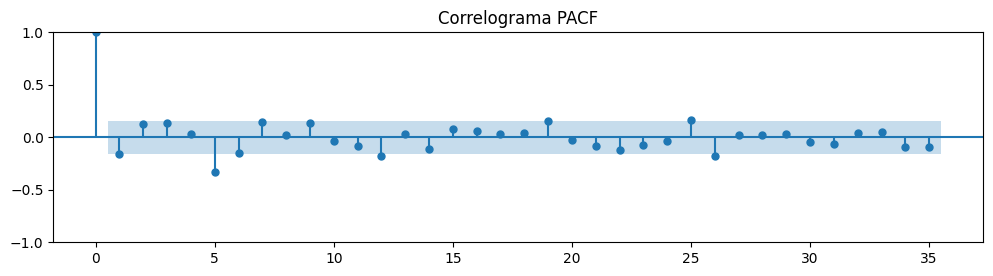

In [35]:
#Grafico del PACF (Partial Autocorrelation Function)
# PACF (Autocorrelación Parcial)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plot_pacf(diff_1, lags=35, ax=plt.gca())
plt.title('Correlograma PACF')
plt.show()

Anlisando el PACF podemos observar que los primeros 2 regazos(logs) parecen casi significativos. Sin embargo mas alla de esos rezagos parece  no son significativos y por lo que es considerado ruido blano, por lo el componenete AR(2).

Otra vez se observa un pico de rezago 5, lo que fortalece que ese es un componenete estacional y que se debe ignorar. Podriamos experimentar con un parametro **p=1 o p=2** y un **P=2**.

In [36]:
# Ajustar el modelo ARIMA(2,1,0)
modelo_1 = ARIMA(TS_train, order=(2, 1, 0),freq='D').fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
#Observamos como se comparta el modelo ARIMA
print(modelo_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 Precio   No. Observations:                  152
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 285.075
Date:                Tue, 10 Jun 2025   AIC                           -564.150
Time:                        16:55:49   BIC                           -555.098
Sample:                    01-01-2021   HQIC                          -560.473
                         - 06-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1326      0.045     -2.921      0.003      -0.222      -0.044
ar.L2          0.1266      0.049      2.605      0.009       0.031       0.222
sigma2         0.0013   7.99e-05     16.785      0.0

In [38]:
#Ajustamos un modelo SARIMA(2,1,0)(2,1,0)7
modelo_2 = SARIMAX(TS_train,order=(2, 1, 0), seasonal_order=(2, 1, 0, 7),freq='D').fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [39]:
#Observamos como se comparta el modelo SARIMA
print(modelo_2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Precio   No. Observations:                  152
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood                 246.912
Date:                           Tue, 10 Jun 2025   AIC                           -483.825
Time:                                   16:55:51   BIC                           -468.975
Sample:                               01-01-2021   HQIC                          -477.791
                                    - 06-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0774      0.046     -1.667      0.095      -0.168       0.014
ar.L2          0.1529      0.060      2.568

In [40]:
# Ajustamos un modelo de suavizamiento exponenecial
model_3= ExponentialSmoothing(TS_train['Precio'], trend='multiplicative', seasonal='multiplicative', seasonal_periods=7).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


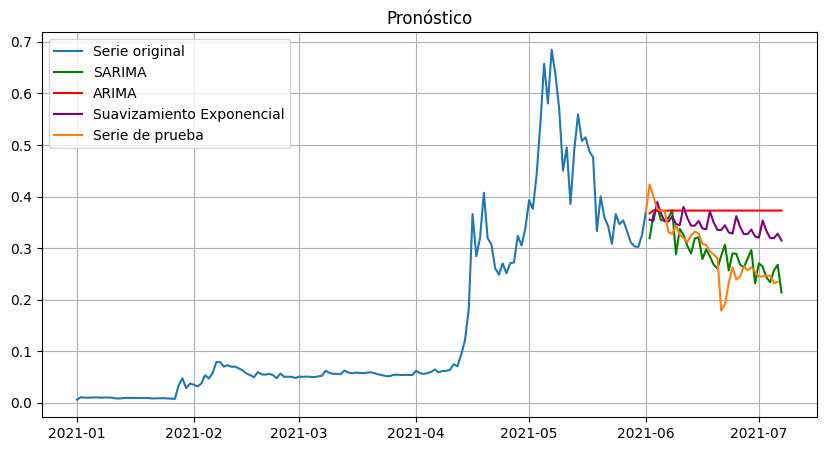

In [41]:
# Obtenemos los pronosticos de cada modelo
forecast_1 = modelo_1.forecast(steps=len(TS_test))
forecast_2 = modelo_2.forecast(steps=len(TS_test))
forecast_3 = model_3.forecast(len(TS_test))

#Graficamos cada prediccion de los modelos para ver como se comportan frente a los datos que realmente sucedieron
plt.figure(figsize=(10, 5))
plt.plot(TS_train, label='Serie original')
plt.plot(forecast_2,label='SARIMA',color='green')
plt.plot(forecast_1, label='ARIMA', color='red')
plt.plot(forecast_3, label='Suavizamiento Exponencial', color='purple')
plt.plot(TS_test, label='Serie de prueba')
plt.title('Pronóstico')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Observando mas cerca la grafica de los Pronosticos

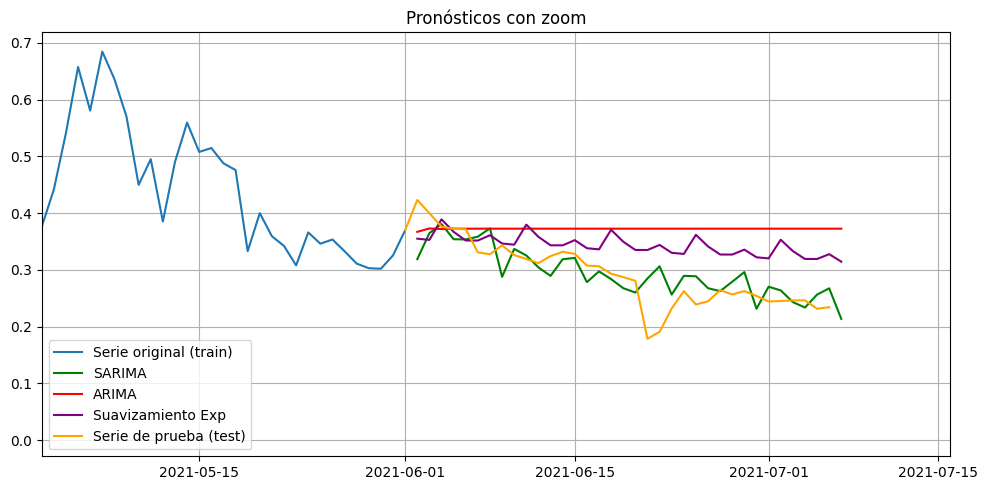

In [42]:
# --- margen de zoom ---
back_days  = 30      # cuánto ver antes del inicio del test
front_days = 10      # cuánto ver después del último pronóstico

zoom_start = TS_test.index.min() - pd.Timedelta(days=back_days)
zoom_end   = TS_test.index.max() + pd.Timedelta(days=front_days)

#Grafica
plt.figure(figsize=(10, 5))
plt.plot(TS_train,label='Serie original (train)',)
plt.plot(forecast_2,label='SARIMA',color='green')
plt.plot(forecast_1,label='ARIMA',color='red')
plt.plot(forecast_3,label='Suavizamiento Exp',color='purple')
plt.plot(TS_test,label='Serie de prueba (test)',color='orange')

plt.title('Pronósticos con zoom')
plt.xlim(zoom_start, zoom_end)
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

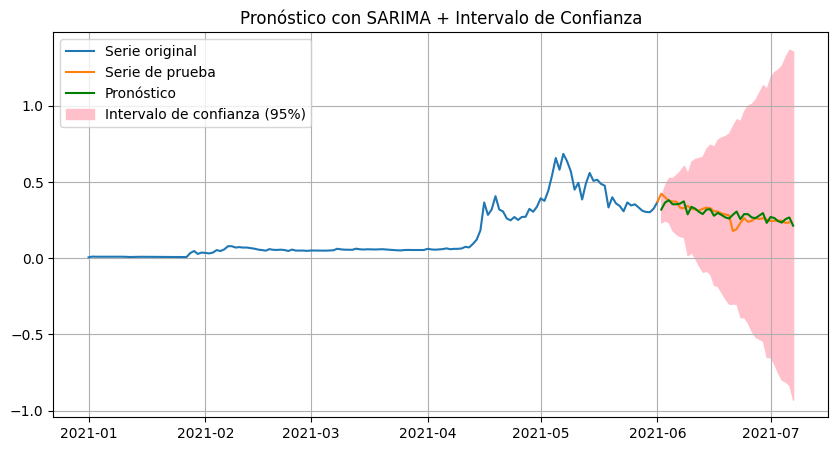

In [43]:
# Obtener pronóstico con intervalos de confianza para el modelo SARIMA
forecast_obj = modelo_2.get_forecast(steps=len(TS_test))
predicciones = forecast_obj.predicted_mean
confianza = forecast_obj.conf_int()

#Grafica
plt.figure(figsize=(10, 5))
plt.plot(TS_train, label='Serie original')
plt.plot(TS_test, label='Serie de prueba')
plt.plot(predicciones, label='Pronóstico', color='green')

# Intervalos de confianza
plt.fill_between(predicciones.index,confianza.iloc[:, 0],confianza.iloc[:, 1],color='pink', alpha=1, label='Intervalo de confianza (95%)')

plt.title('Pronóstico con SARIMA + Intervalo de Confianza')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
#Obtenemos los residos del modelo SARIMA
modelo_2.resid

,0
Date,
2021-01-01,0.005685
2021-01-02,0.004930
2021-01-03,-0.000844
2021-01-04,-0.000003
2021-01-05,0.000153
...,...
2021-05-28,-0.060294
2021-05-29,0.025725
2021-05-30,0.053681


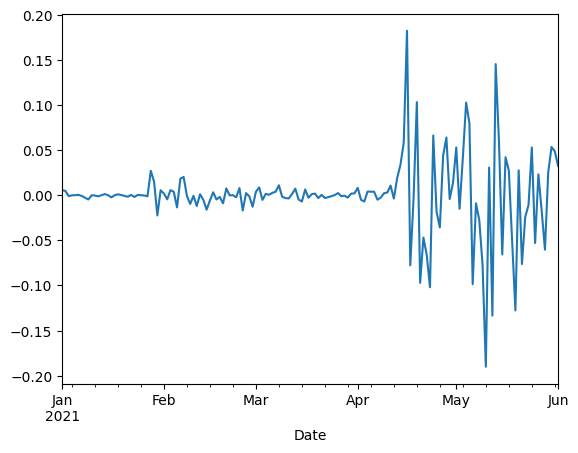

In [45]:
#lo gráficamos para poderlo apreciar de una mejor manera
modelo_2.resid.plot()
plt.show()

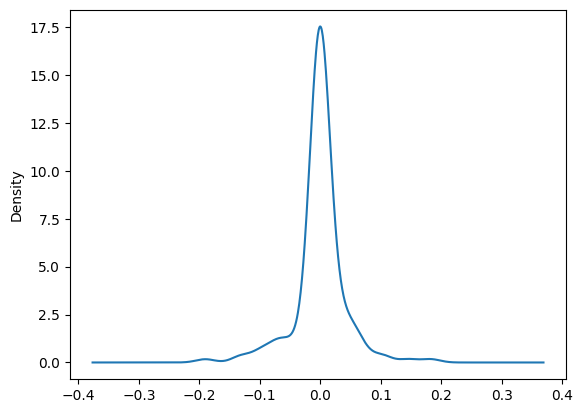

In [46]:
#Graficamos la distribucion de los residuos
modelo_2.resid.plot(kind='kde')
plt.show()

In [47]:
#Obtenemos el MAE (Mean Absolute Error)
print(f"MAE: {modelo_2.mae}")

MAE: 0.02216115499836316


In [48]:
#Obtenemos el MSE (Mean Squared Error) del modelo SARIMA
print(f"MSE: {modelo_2.mse}")

MSE: 0.001750234166302535


In [49]:
#Calculamosm el valor de MAPE
valores_reales = np.array(TS_test['Precio'])
predicciones = np.array(forecast_2)

n = len(TS_test['Precio'])
mape = 0

for i in range(n):
  if valores_reales[i] != 0:
    mape += abs((valores_reales[i] - predicciones[i]) / valores_reales[i])

mape = (mape / n) * 100
print(f"MAPE: {mape}")


MAPE: 10.482862004830428


#Explicación de resultados y medidas de desempeño del modelo (MAE, MAPE, MSE, etc.)


Algunos de los resultados y medidas de desempeño comunes utilizados en la evaluación de modelos:

* AIC (Criterio de información de Akaike)
El AIC es una medida de la calidad relativa de los modelos estadísticos para un conjunto de datos dado.
* BIC (Criterio de información bayesiano)
El BIC es similar al AIC, pero tiene en cuenta el tamaño de la muestra.

Recordemos que **AIC y BIC se utilizan para la comparación de modelos.**
**Un AIC o BIC menor indica un mejor modelo**, incluso si ambos valores son negativos.

* MAPE (Error porcentual absoluto medio)
El MAPE es una medida del error de predicción de un modelo de pronóstico.
* MAE (Mean Absolute Error): Es la media de las diferencias absolutas entre las predicciones y los valores reales. El MAE mide la magnitud promedio de los errores en un conjunto de predicciones, sin tener en cuenta su dirección. Un MAE más bajo indica un mejor ajuste del modelo.

* MSE (Mean Squared Error): Es la media de los errores al cuadrado entre las predicciones y los valores reales. El MSE penaliza los errores grandes más que el MAE, lo que lo hace más sensible a los valores atípicos. Un MSE más bajo indica un mejor ajuste del modelo.

* RMSE (Root Mean Squared Error): Es la raíz cuadrada del MSE. El RMSE tiene la misma unidad que la variable de respuesta original, lo que facilita su interpretación en términos de la escala de la variable. Al igual que el MSE, un RMSE más bajo indica un mejor ajuste del modelo.

* MAPE (Mean Absolute Percentage Error): Es la media de los errores porcentuales absolutos entre las predicciones y los valores reales, expresada como un porcentaje. El MAPE proporciona una medida relativa del error en relación con el valor real. Es útil cuando los errores porcentuales son más relevantes que los errores absolutos. Un MAPE más bajo indica un mejor ajuste del modelo.

Los tres resultados proporcionan los resultados y medidas de desempeño del modelo, analicemos cada uno de ellos.


| Medida  | Valor obtenido | Observaciones |
|-----------|-----------|-----------|
|  **MAPE (Error porcentual absoluto medio)**       |  **10.48**       |  En promedio, las predicciones del modelo tienen un error del 10,48% con respecto a los valores reales.   |
|  **MAE (Error Absoluto Medio)**       |  **0.0222**       | Indica que, en promedio, el modelo comete un error de 0.0222 unidades al predecir el precio.   |
| **MSE (Error Cuadrático Medio):**     | **0.00175**         | Implica que el modelo tiene un error cuadrático medio pequeño, lo cual refuerza que el modelo tiene un buen ajuste.      |
| **RMSE (Raíz del Error Cuadrático Medio):**         | **0.0418**         | Confirma que los errores de predicción son bajos en promedio.     |



#Conclusiones y recomendaciones



El modelo **SARIMAX(2,1,0)(2,1,0,7)** fue el que mostró **mejor desempeño**, logrando capturar la **estacionalidad semanal** presente en los datos. Sus coeficientes son estadísticamente significativos y sus valores de **AIC**, **BIC** y **Log-Likelihood** indican un mejor ajuste respecto al modelo ARIMA sin estacionalidad.

Las métricas de error, como el **MAE** y el **MSE**, reflejan un **buen nivel de precisión** en las predicciones. Sin embargo, las pruebas estadísticas indican que los **residuos no son normales** y presentan **heterocedasticidad** , lo cual sugiere que el modelo no capta por completo toda la estructura de la serie.


**Recomendaciones:**
- Probar transformaciones en los datos (por ejemplo, logaritmos) o utilizar modelos alternativos que controlen la heterocedasticidad.
- Explorar otras estacionalidades posibles (mensual, trimestral).
- Realizar **validación fuera de muestra** para verificar que el modelo generaliza correctamente.
- Evaluar el comportamiento de las **predicciones futuras** para asegurarse de que el modelo sigue siendo útil más allá del periodo de entrenamiento.
